In [1]:
%matplotlib inline
import torch
import torchvision
import numpy as np
import time
import torch.nn.functional as F
from PIL import Image

import sys
sys.path.append('../code/')
import d2lzh_pytorch as d2l
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

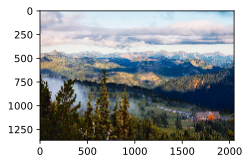

In [2]:
d2l.set_figsize()
content_img=Image.open('../data/rainier.jpg')
d2l.plt.imshow(content_img);

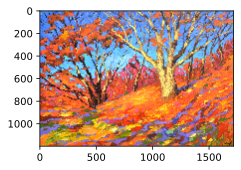

In [3]:
d2l.set_figsize()
style_img=Image.open('../data/autumn_oak.jpg')
d2l.plt.imshow(style_img);

In [20]:
rgb_mean=np.array([0.485,0.456,0.406])
rgb_std=np.array([0.229,0.224,0.225])
def preprocess(PIL_img,img_shape):
    process=torchvision.transforms.Compose([
        torchvision.transforms.Resize(img_shape),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=rgb_mean,std=rgb_std)
    ])
    return process(PIL_img).unsqueeze(dim=0) #(batch_size,3,H,W)

def postprocess(img_tensor):
    inv_normalize=torchvision.transforms.Normalize(
        mean=-rgb_mean/rgb_std,
        std=1/rgb_std)
    to_PIL_image=torchvision.transforms.ToPILImage()
    return to_PIL_image(inv_normalize(img_tensor[0].cpu()).clamp(0,1))

In [21]:
pretrained_net=torchvision.models.vgg19(pretrained=True,progress=True)

In [22]:
pretrained_net

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [23]:
style_layers,content_layers=[0,5,10,19,28],[25]

In [24]:
net_list=[]
for i in range(max(content_layers+style_layers)+1):
    net_list.append(pretrained_net.features[i])
net=torch.nn.Sequential(*net_list)

In [25]:
def extract_features(X,content_layers,style_layers):
    contents=[]
    styles=[]
    for i in range(len(net)):
        X=net[i](X)
        if i in style_layers:
            styles.append(X)
        if i in content_layers:
            contents.append(X)
    return contents,styles

In [26]:
def get_contents(img_shape,device):
    content_X=preprocess(content_img,img_shape).to(device)
    contents_Y,_=extract_features(content_X,content_layers,style_layers)
    return content_X,contents_Y

def get_styles(img_shape,device):
    style_X=preprocess(style_img,img_shape).to(device)
    _,styles_Y=extract_features(style_X,content_layers,style_layers)
    return style_X,styles_Y

In [27]:
def content_loss(Y_hat,Y):
    return F.mse_loss(Y_hat,Y)

In [28]:
def gram(X):
    num_channels,n=X.shape[1],X.shape[2]*X.shape[3]
    X=X.view(num_channels,n)
    return torch.matmul(X,X.t())/(num_channels*n)

In [29]:
def style_loss(Y_hat,gram_Y):
    return F.mse_loss(gram(Y_hat),gram_Y)

In [30]:
def tv_loss(Y_hat):
    return 0.5 * (F.l1_loss(Y_hat[:,:,1:,:],Y_hat[:,:,:-1,:])+F.l1_loss(Y_hat[:, :, :, 1:], Y_hat[:, :, :, :-1]))

In [46]:
content_weight,style_weight,tv_weight=1,1e3,10

def compute_loss(X,contents_Y_hat,styles_Y_hat,contents_Y,styles_Y_gram):
    contents_l= [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(
        contents_Y_hat,contents_Y)]
    styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(
        styles_Y_hat, styles_Y_gram)]
    tv_l = tv_loss(X) * tv_weight
    l = sum(styles_l) + sum(contents_l) + tv_l
    return contents_l, styles_l, tv_l, l

In [47]:
class GeneratedImage(torch.nn.Module):
    def __init__(self,img_shape):
        super(GeneratedImage,self).__init__()
        self.weight=torch.nn.Parameter(torch.rand(*img_shape))
        
    def forward(self):
        return self.weight

In [48]:
def get_inits(X,device,lr,styles_Y):
    gen_img=GeneratedImage(X.shape).to(device)
    gen_img.weight.data=X.data
    optimizer=torch.optim.Adam(gen_img.parameters(),lr=lr)
    styles_Y_gram=[gram(Y) for Y in styles_Y]
    return gen_img(),styles_Y_gram,optimizer

In [52]:
def train(X,contents_Y,styles_Y,device,lr,max_epochs,lr_decay_epoch):
    print('training on ',device)
    X,styles_Y_gram,optimizer=get_inits(X,device,lr,styles_Y)
    scheduler=torch.optim.lr_scheduler.StepLR(optimizer,lr_decay_epoch,gamma=0.1)
    for i in range(max_epochs):
        start =time.time()
        contents_Y_hat,styles_Y_hat=extract_features(X,content_layers,style_layers)
        contents_l,styels_l,tv_l,l=compute_loss(X,contents_Y_hat,styles_Y_hat,contents_Y,styles_Y_gram)
        
        optimizer.zero_grad()
        l.backward(retain_graph=True)
        optimizer.step()
        scheduler.step()
        
        if i%50==0 and i!=0:
            print('epoch %3d content loss %.2f, style loss %.2f, TV loss %.2f ,%.2f sec'
                % (i,sum(contents_l).item(),sum(styels_l).item(),tv_l.item(),time.time()-start))

    return X.detach()

In [50]:
img_shape=(150,225)
net=net.to(device)
content_X,contents_Y=get_contents(img_shape,device)
style_X,styles_Y=get_styles(img_shape,device)
output=train(content_X,contents_Y,styles_Y,device,0.01,500,200)

training on  cuda
epoch  20 content loss 0.19, style loss 2.12, TV loss 1.28 ,0.61 sec
epoch  40 content loss 0.23, style loss 1.32, TV loss 1.33 ,0.61 sec
epoch  60 content loss 0.24, style loss 1.00, TV loss 1.31 ,0.61 sec
epoch  80 content loss 0.24, style loss 0.88, TV loss 1.25 ,0.61 sec
epoch 100 content loss 0.24, style loss 0.81, TV loss 1.20 ,0.61 sec
epoch 120 content loss 0.24, style loss 0.77, TV loss 1.16 ,0.61 sec
epoch 140 content loss 0.24, style loss 0.74, TV loss 1.13 ,0.61 sec
epoch 160 content loss 0.23, style loss 0.72, TV loss 1.11 ,0.61 sec
epoch 180 content loss 0.24, style loss 0.70, TV loss 1.08 ,0.61 sec
epoch 200 content loss 0.24, style loss 0.68, TV loss 1.06 ,0.61 sec
epoch 220 content loss 0.24, style loss 0.68, TV loss 1.06 ,0.61 sec
epoch 240 content loss 0.23, style loss 0.68, TV loss 1.05 ,0.61 sec
epoch 260 content loss 0.23, style loss 0.68, TV loss 1.05 ,0.61 sec
epoch 280 content loss 0.23, style loss 0.68, TV loss 1.05 ,0.61 sec
epoch 300 conten

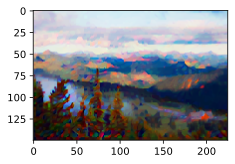

In [53]:
d2l.plt.imshow(postprocess(output));

In [54]:
image_shape = (300, 450)
_, content_Y = get_contents(image_shape, device)
_, style_Y = get_styles(image_shape, device)
X = preprocess(postprocess(output), image_shape).to(device)
big_output = train(X, content_Y, style_Y, device, 0.01, 500, 200)

training on  cuda
epoch  50 content loss 0.34, style loss 0.63, TV loss 0.79 ,1.72 sec
epoch 100 content loss 0.31, style loss 0.50, TV loss 0.74 ,1.72 sec
epoch 150 content loss 0.29, style loss 0.46, TV loss 0.72 ,1.72 sec
epoch 200 content loss 0.28, style loss 0.43, TV loss 0.70 ,1.73 sec
epoch 250 content loss 0.28, style loss 0.43, TV loss 0.70 ,1.73 sec
epoch 300 content loss 0.28, style loss 0.42, TV loss 0.69 ,1.73 sec
epoch 350 content loss 0.28, style loss 0.42, TV loss 0.69 ,1.73 sec
epoch 400 content loss 0.28, style loss 0.42, TV loss 0.69 ,1.73 sec
epoch 450 content loss 0.28, style loss 0.42, TV loss 0.69 ,1.73 sec


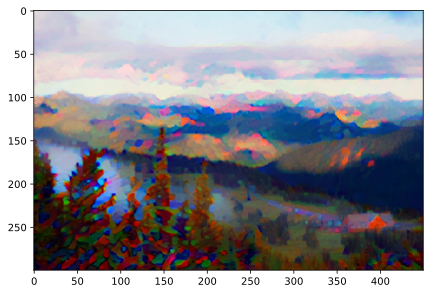

In [55]:
d2l.set_figsize((7, 5))
d2l.plt.imshow(postprocess(big_output));

In [57]:
postprocess(big_output).save('art.jpg')